In [1]:
#pip install shap

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import shap 
from sklearn.model_selection import KFold

df_MMRT = pd.read_csv('WorldBankDatasets/Cleaned/AllMerged_Threshold_85_n3_MMRT.csv')
df_MMRTNE = pd.read_csv('WorldBankDatasets/Cleaned/AllMerged_Threshold_85_n3_MMRTNE.csv')
df_OECD = pd.read_csv('OECD/HEALTH_MERGED.csv')

In [6]:
######  select which df to use 

#df = df_MMRTNE
#indicator_y = 'SH.STA.MMRT.NE'

df = df_MMRT
indicator_y = 'SH.STA.MMRT'


#df = df_OECD
#indicator_y = 'MATIMATM'



## Simple Linear Regression

In [7]:
# First need to encode the country 

# Create a LabelEncoder instance for each categorical column
country_encoder = LabelEncoder()

# Encode the categorical columns
data_encoded = df.copy(deep = True)
data_encoded['Country'] = country_encoder.fit_transform(data_encoded['Country'])

In [8]:
# pull out Maternal Mortality as the predictor variable 
X = data_encoded.drop(columns= indicator_y)
y = data_encoded[indicator_y]

### 5 fold cross validation 

In [9]:
# Create a list to store the mean squared errors (MSE) for each fold
mse_scores = []
r2_scores = []

# Establish a linear regression model
model = LinearRegression()

# Create a KFold cross-validator with 5 folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform 5-fold cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]

    
    # Train the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Calculate the mean squared error (MSE) for this fold
    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)
    r2 = r2_score(y_test, y_pred)
    r2_scores.append(r2)

# Calculate the mean and standard deviation of the MSE scores and r2 scores
mean_mse = np.mean(mse_scores)
std_mse = np.std(mse_scores)
mean_r2 = np.mean(r2_scores)
std_r2 = np.std(r2_scores)

print(f"Average Mean Squared Error (MSE): {mean_mse}")
print(f"Standard Deviation of Mean Squared Error (MSE): {std_mse}")
print(f"Mean R-squared (R2): {mean_r2}")
print(f"Standard Deviation of R-squared (R2): {std_r2}")

Average Mean Squared Error (MSE): 1225.3765764134505
Standard Deviation of Mean Squared Error (MSE): 2307.191504388445
Mean R-squared (R2): -5.958687230962424
Standard Deviation of R-squared (R2): 13.20023477851284


### Single Model Case

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 57.05265498222212
R-squared: 0.5413727115014243


In [9]:
def plot_linear_reg(X, y, yp, country, title):

 # X - X_test
 # y - y_test
 # yp - y_pred
 # country - list of country abbreviations ie. ['USA']

    if country == None: 

        # Plot the data points and the regression line
        plt.figure(figsize=(30, 20))
        plt.scatter(X['Year'], y, color='blue', label='Data')
        plt.scatter(X['Year'], yp, color='red',  label='Linear Regression')
        plt.xlabel('Year')
        plt.ylabel('Maternal Mortality Ratio')
        plt.title(title)
        plt.legend()
        plt.figure(figsize=(30, 20))
        plt.show()
        
    else: 
        # Country encoding 
        encoded_values = country_encoder.transform(country)
        # looking at just the secific country predictions in test partition

        # Use boolean indexing to select the subset of the DataFrame
        condition = X['Country'].isin(encoded_values)
        X_test = X[condition]['Year']
        y_test = y.loc[X_test.index]

        # take the array index in order to pull the relevant y_pred  
        index_positions = [y.index.get_loc(index) for index in X_test.index]
        
        y_pred = [yp[i] for i in index_positions]
        
        # Plot the data points and the regression line
        plt.figure(figsize=(15, 10))
        plt.scatter(X_test, y_test, color='blue', label='Data')
        plt.scatter(X_test, y_pred, color='red',  label='Linear Regression')
        plt.xlabel('Year')
        plt.ylabel('Maternal Mortality Ratio')
        plt.title(title)
        plt.legend()
        plt.show()

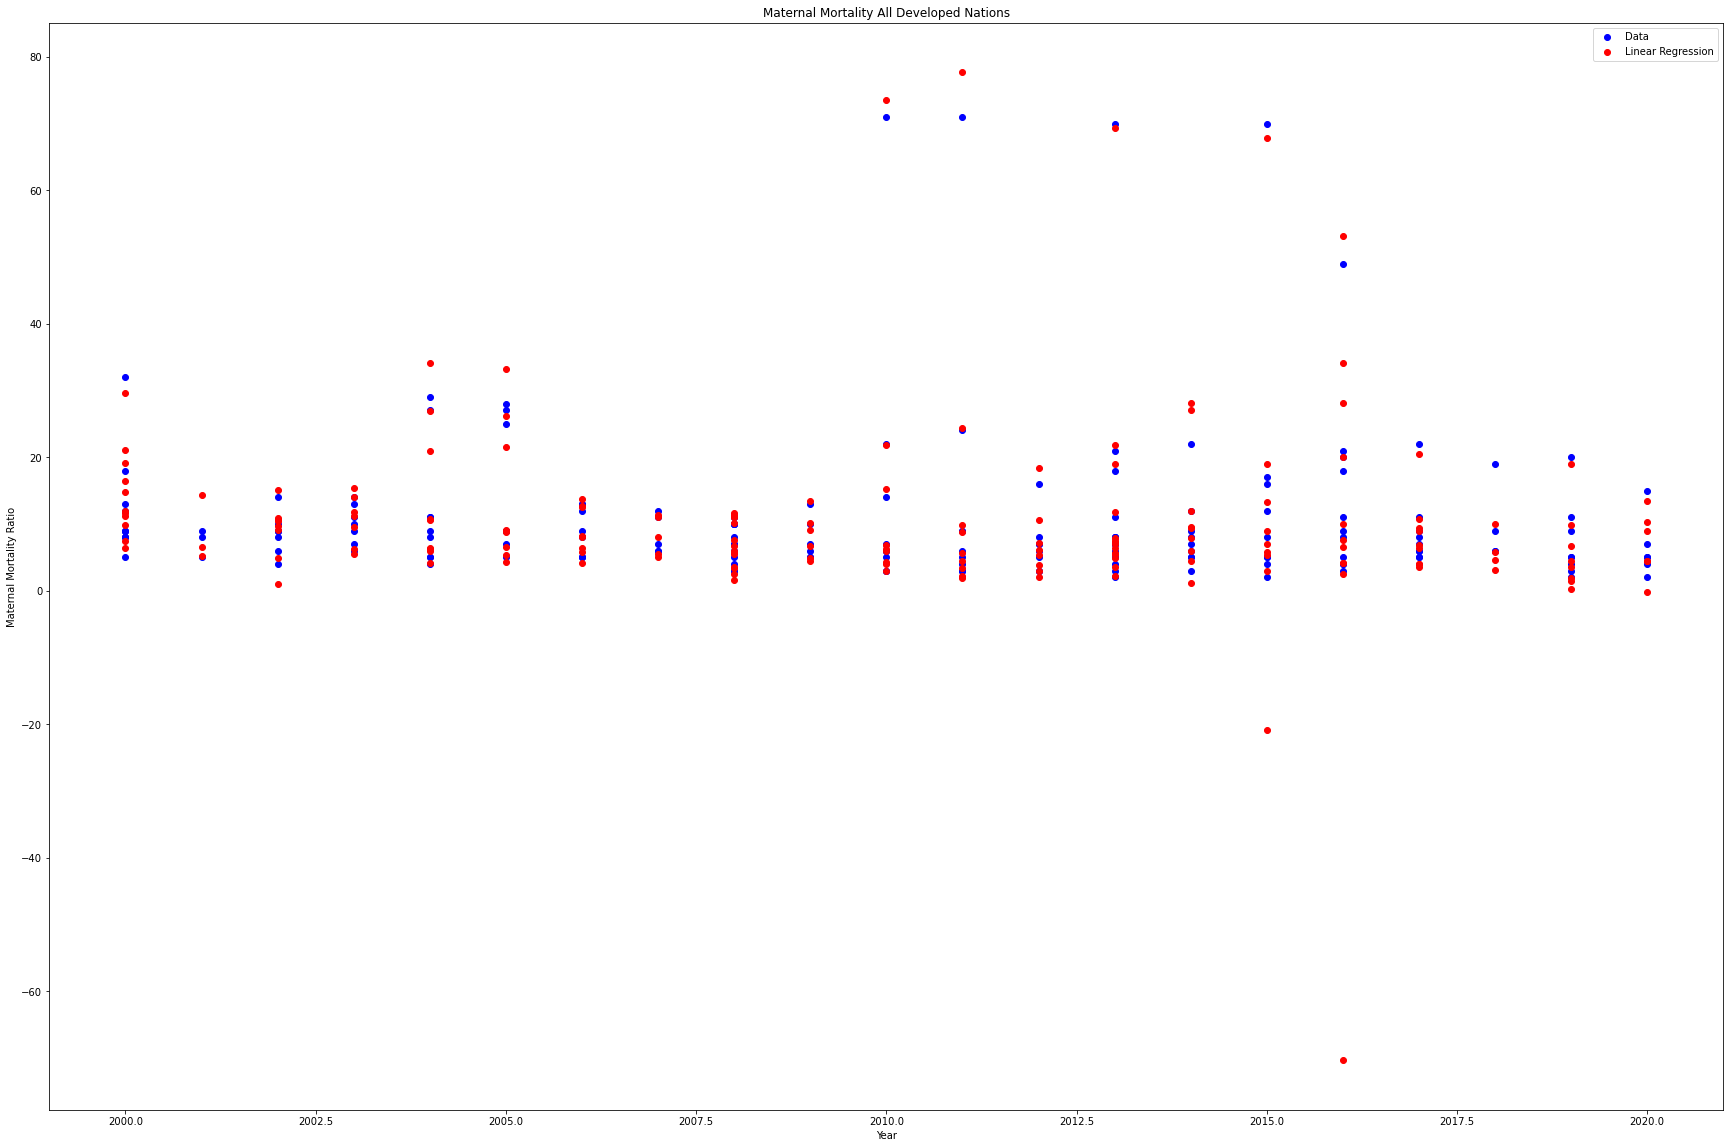

<Figure size 2160x1440 with 0 Axes>

In [10]:
plot_linear_reg(X_test, y_test, y_pred, country = None, title = 'Maternal Mortality All Developed Nations')

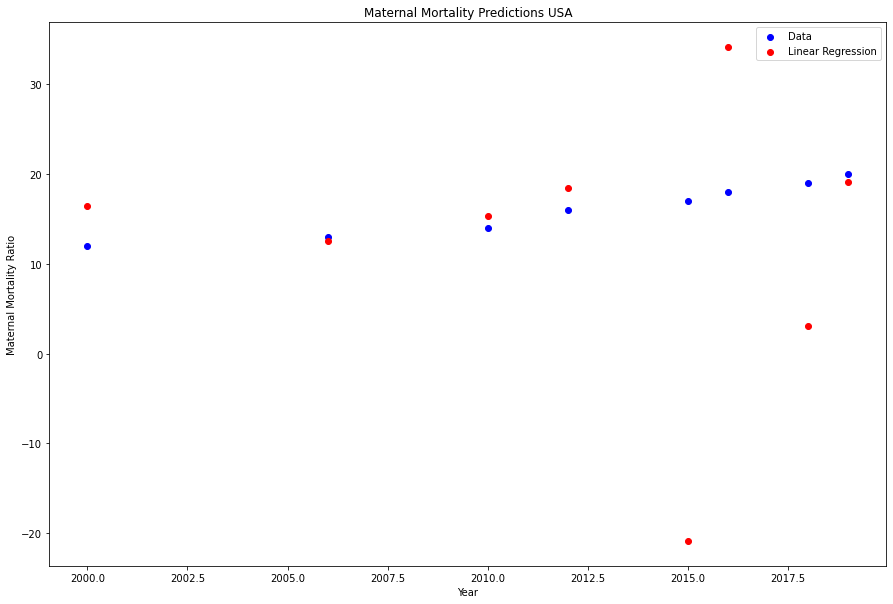

In [11]:
plot_linear_reg(X_test, y_test, y_pred, country = ['USA'], title = 'Maternal Mortality Predictions USA')

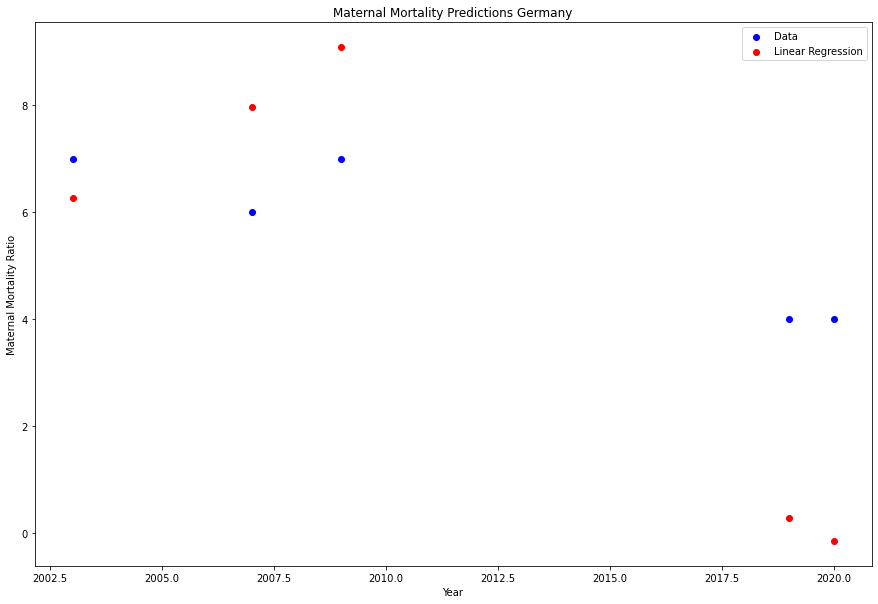

In [12]:
plot_linear_reg(X_test, y_test, y_pred, country = ['DEU'], title = 'Maternal Mortality Predictions Germany')

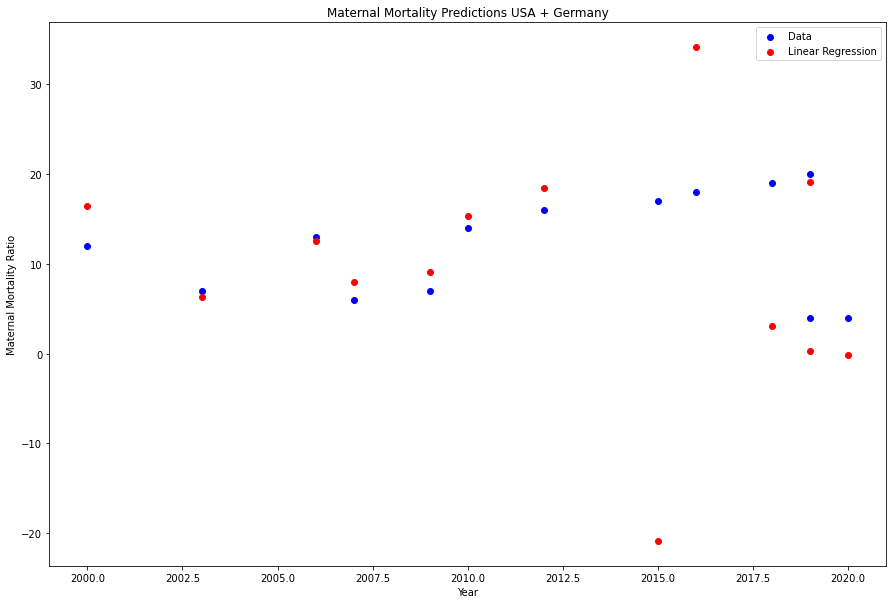

In [13]:
plot_linear_reg(X_test, y_test, y_pred, country = ['DEU', 'USA'], title = 'Maternal Mortality Predictions USA + Germany')

## Shapley Values

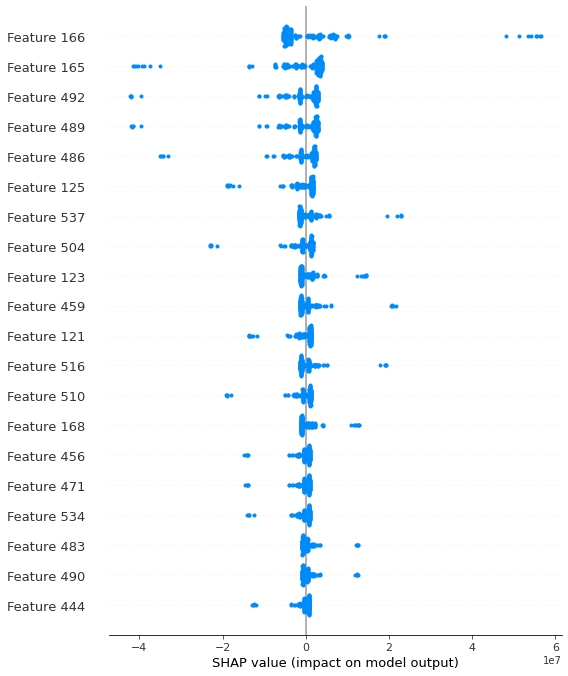

In [14]:
explainer = shap.LinearExplainer(model, X_train)

# look at the features for all instances
shap_values = explainer.shap_values(X_test) 

shap.summary_plot(shap_values)

#shap_values.shape

In [15]:
print(f'These are the top features: {X_train.columns[537]}, {X_train.columns[513]}, {X_train.columns[462]}, {X_train.columns[534]}')
      

These are the top features: SP.POP.1524.TO.UN, SP.POP.1217.TO.UN, SP.POP.0612.TO.UN, SP.POP.1419.TO.UN


In [16]:
# look at the features for the USA predictions 
encoded_values = country_encoder.transform(['USA'])

condition = X_test['Country'].isin(encoded_values)
X_country_lens = X_test[condition]['Year']

shap_values = explainer.shap_values(X_test.loc[X_country_lens.index]) 
#shap.summary_plot(shap_values)

### A look at coeffecients 

In [17]:
# Get the coefficients and feature names
coefficients = model.coef_
feature_names =  X.columns 

# Create a dictionary with feature names and their coefficients
coefficients_dict = dict(zip(feature_names, coefficients))

# Sort the features by their absolute coefficients in descending order
sorted_features = sorted(coefficients_dict.items(), key=lambda x: abs(x[1]), reverse=True)

# Print the top 10 sorted features
for feature, coefficient in sorted_features[0:11]:
    print(f"{feature}: {coefficient}")

SL.EMP.WORK.MA.ZS: 745.760982572259
SL.EMP.VULN.MA.ZS: 732.5647297438841
SL.EMP.MPYR.MA.ZS: 732.5044968545318
SL.EMP.SELF.FE.ZS: 670.5125917333935
SL.EMP.WORK.FE.ZS: 562.8297155683206
SL.IND.EMPL.MA.ZS: 550.1724486224996
SL.AGR.EMPL.MA.ZS: 550.1586698044783
SL.SRV.EMPL.MA.ZS: 550.0225676926683
UIS.GER.1T6.GPI: -296.1989762542135
SH.MMR.RISK.ZS: 261.98825764042726
UIS.SLE.123.GPI: -219.84236727824
